# Gender and Age detecting model
## BDA-2206
## Damenova Dana, Abdykarimov Amir

Importing libraries, connecting to drive and loading a test image to see how our pretrained model works

In [1]:
import cv2 as cv
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
input_image_path = "/content/drive/MyDrive/pretrained_model/test_image.jpeg"
input_image = cv.imread(input_image_path)

# Writing a function for detecting coordinates of faces if the confidence score is > 0.7 using a pretrained face Detection model

In [5]:
def getFace(faceDetectionModel, inputImage, conf_threshold=0.7):
  cpy_input_image = inputImage.copy()

  frameWidth = cpy_input_image.shape[1]
  frameHeight = cpy_input_image.shape[0]

  blob = cv.dnn.blobFromImage(cpy_input_image, scalefactor=1, size=(300, 300), mean=(104, 117, 123), crop=False) #preprocessed image

  faceDetectionModel.setInput(blob)
  detections = faceDetectionModel.forward()

  bounding_boxes = []
  for i in range(detections.shape[2]):  #detections is an array having [no.of.images/batch size, classes/channels, i-th detections, confidence_score]
    confidence_score = detections[0, 0, i, 2] #gets the confidence score for i-detections, 4-th index(value:2) shows confidence score

    if confidence_score > conf_threshold: #get the co-ordinates of the bounding boxes only if its detected as a face, confidence score sets the minimum limit
      x1 = int(detections[0,0,i,3] * frameWidth)
      y1 = int(detections[0,0,i,4] * frameHeight)
      x2 = int(detections[0,0,i,5] * frameWidth)
      y2 = int(detections[0,0,i,6] * frameHeight)
      bounding_boxes.append([x1, y1, x2, y2])

      cv.rectangle(cpy_input_image, (x1,y1), (x2,y2), color=(255, 0, 0), thickness=2)
  return cpy_input_image, bounding_boxes

# Using opencv face detector to detect a face on the test image

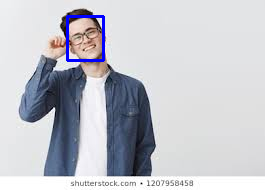

In [6]:
#face detection model
faceProto = '/content/drive/MyDrive/pretrained_model/opencv_face_detector.pbtxt'
faceModel = '/content/drive/MyDrive/pretrained_model/opencv_face_detector_uint8.pb'

faceNet = cv.dnn.readNet(faceModel, faceProto)

detected_image, bounding_boxes = getFace(faceNet, input_image)

cv2_imshow(detected_image)

## Importing genderNet from openCv in caffemodel extension and model definition file gender_deploy.prototxt

In [7]:
genderProto = "/content/drive/MyDrive/pretrained_model/gender_deploy.prototxt"
genderModel = "/content/drive/MyDrive/pretrained_model/gender_net.caffemodel"
genderNet = cv.dnn.readNet(genderModel, genderProto)

genderList = ['Male', 'Female']

## Importing age_net from openCv in caffemodel extension with model definition file age_deploy.prototxt

In [8]:
ageProto = "/content/drive/MyDrive/pretrained_model/age_deploy.prototxt"
ageModel = "/content/drive/MyDrive/pretrained_model/age_net.caffemodel"
ageNet = cv.dnn.readNet(ageModel, ageProto)

ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']

### If the model has found bounding boxes, it will start going though the list of detected faces, preprocess the image and set it as an input first for the genderNet pretrained model and get the prediction. Then it will do the same for the age and show the age range along with the confidene score.

Predicted Gender: Female, Confidence Score: 0.7443660497665405
Predicted Age Range: (25-32), Confidence Score: 0.9771376848220825



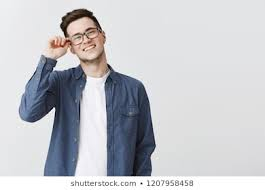

In [9]:
if not bounding_boxes:
    print("No faces detected in the image")
else:
    for bounding_box in bounding_boxes:
        x1, y1, x2, y2 = bounding_box  # Assign bounding box coordinates
        detected_face_box = input_image[y1:y2, x1:x2]  # Extract face region

        # Preprocess face image for gender prediction
        detected_face_blob = cv.dnn.blobFromImage(
            detected_face_box,
            scalefactor=1,
            size=(227, 227),
            mean=([78.4263377603, 87.7689143744, 114.895847746]),
            crop=False
        )
        genderNet.setInput(detected_face_blob)
        genderPrediction = genderNet.forward()
        gender = genderList[genderPrediction[0].argmax()]
        print(f"Predicted Gender: {gender}, Confidence Score: {genderPrediction[0].max()}")

        ageNet.setInput(detected_face_blob)
        agePrediction = ageNet.forward()
        age = ageList[agePrediction[0].argmax()]
        print(f"Predicted Age Range: {age}, Confidence Score: {agePrediction[0].max()}")

    print()

cv2_imshow(input_image)


The model seems to work relatively okay. Now we should see the performance on the test data. Let's first test the gender model.  gender_test contains 2 folders and based on the folder it can see whether the model labels the image correctly.

In [10]:
import os
import cv2 as cv
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Paths for the test data
test_data_path = "/content/drive/MyDrive/pretrained_model/gender_test"
categories = ["Male", "Female"]


def detect_faces(image):
    h, w = image.shape[:2]
    blob = cv.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300),
                                mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
    faceNet.setInput(blob)
    detections = faceNet.forward()
    boxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            x1 = int(detections[0, 0, i, 3] * w)
            y1 = int(detections[0, 0, i, 4] * h)
            x2 = int(detections[0, 0, i, 5] * w)
            y2 = int(detections[0, 0, i, 6] * h)
            boxes.append((x1, y1, x2, y2))
    return boxes

# Variables to store predictions and ground truths
y_true = []
y_pred = []

# Process test data
for category in categories:
    label = genderList.index(category)  # 0 for Male, 1 for Female
    folder_path = os.path.join(test_data_path, category)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        image = cv.imread(file_path)
        if image is None:
            continue
        faces = detect_faces(image)
        if not faces:
            print(f"No face detected in {file_name}")
            continue

        for box in faces:
            x1, y1, x2, y2 = box
            face = image[y1:y2, x1:x2]
            # Preprocess the face
            blob = cv.dnn.blobFromImage(
                face,
                scalefactor=1,
                size=(227, 227),
                mean=([78.4263377603, 87.7689143744, 114.895847746]),
                crop=False
            )
            genderNet.setInput(blob)
            prediction = genderNet.forward()
            predicted_label = np.argmax(prediction[0])  # 0 for Male, 1 for Female
            y_pred.append(predicted_label)
            y_true.append(label)

# Calculate performance metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=genderList))
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")


No face detected in 20240609_182639.jpg
No face detected in 0146.jpg
No face detected in 0011.jpg
No face detected in 0110.jpg
No face detected in 0200.jpg
Classification Report:
              precision    recall  f1-score   support

        Male       0.60      0.76      0.67       103
      Female       0.70      0.52      0.60       109

    accuracy                           0.64       212
   macro avg       0.65      0.64      0.63       212
weighted avg       0.65      0.64      0.63       212

Accuracy: 0.64


The accuracy is acceptable but not high. There is certainly a room for improvement.

In [11]:
import pandas as pd
import os
import cv2 as cv
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

test_age_path = "/content/drive/MyDrive/pretrained_model/age_dataset"
images_path = os.path.join(test_age_path, "test")
csv_path = os.path.join(test_age_path, "age_mapping.csv")

data = pd.read_csv(csv_path)

ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
ageMapping = {
    '(0-2)': 'YOUNG', '(4-6)': 'YOUNG', '(8-12)': 'YOUNG', '(15-20)': 'YOUNG',
    '(25-32)': 'MIDDLE', '(38-43)': 'MIDDLE', '(48-53)': 'MIDDLE',
    '(60-100)': 'OLD'
}

y_true = []
y_pred = []

# Process only files listed in the CSV
for _, row in data.iterrows():
    file_name, true_age_group = row['ID'], row['Class']
    file_path = os.path.join(images_path, file_name)

    if not os.path.exists(file_path):
        continue

    y_true.append(true_age_group)  # Append true label

    image = cv.imread(file_path)
    if image is None:
        y_pred.append('UNKNOWN')
        continue

    faces = detect_faces(image)
    if not faces:
        y_pred.append('UNKNOWN')
        continue

    # Predict for the first face detected
    x1, y1, x2, y2 = faces[0]
    face = image[y1:y2, x1:x2]

    # Preprocess for age prediction
    blob = cv.dnn.blobFromImage(
        face,
        scalefactor=1,
        size=(227, 227),
        mean=([78.4263377603, 87.7689143744, 114.895847746]),
        crop=False
    )
    ageNet.setInput(blob)
    agePrediction = ageNet.forward()
    predicted_age_range = ageList[np.argmax(agePrediction[0])]
    predicted_age_group = ageMapping[predicted_age_range]

    y_pred.append(predicted_age_group)

# Remove entries with 'UNKNOWN' predictions
valid_indices = [i for i, pred in enumerate(y_pred) if pred != 'UNKNOWN']
y_true_filtered = [y_true[i] for i in valid_indices]
y_pred_filtered = [y_pred[i] for i in valid_indices]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_true_filtered, y_pred_filtered, target_names=['YOUNG', 'MIDDLE', 'OLD']))

# Compute metrics
accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
precision = precision_score(y_true_filtered, y_pred_filtered, average='weighted')
recall = recall_score(y_true_filtered, y_pred_filtered, average='weighted')
f1 = f1_score(y_true_filtered, y_pred_filtered, average='weighted')

# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Classification Report:
              precision    recall  f1-score   support

       YOUNG       0.62      0.56      0.59       149
      MIDDLE       0.00      0.00      0.00        24
         OLD       0.37      0.54      0.44        80

    accuracy                           0.50       253
   macro avg       0.33      0.37      0.34       253
weighted avg       0.48      0.50      0.49       253

Accuracy: 0.50
Precision: 0.48
Recall: 0.50
F1-Score: 0.49


As we can see, genderNet showed accuracy of 0.64 on the test set on unseen data from random samples of data taken from https://www.kaggle.com/datasets/humairmunir/gender-recognizer, and ageNet showed accuracy 0.5 even when it classifies on 3 output classes instead of initial 8
 (Mapping: Young - 0-20, Middle - 25-53, Old - 60+ ). Age testset was taken from https://www.kaggle.com/datasets/arashnic/faces-age-detection-dataset. Now let's imrove our models' performance. <br>

---


 Looking at the architecture:

In [12]:
for layer_id, layer_name in enumerate(genderNet.getLayerNames()):
    layer = genderNet.getLayer(genderNet.getLayerId(layer_name))
    print(f"Layer {layer_id + 1}: {layer_name}")
    print(f"Type: {layer.type}")
    if hasattr(layer, 'blobs') and len(layer.blobs) > 0:
        print(f"  Number of weights: {len(layer.blobs)}")
        for i, blob in enumerate(layer.blobs):
            print(f"  Blob {i + 1}: Shape: {blob.shape}")


Layer 1: conv1
Type: Convolution
  Number of weights: 2
  Blob 1: Shape: (96, 3, 7, 7)
  Blob 2: Shape: (1, 1, 1, 96)
Layer 2: relu1
Type: ReLU
Layer 3: pool1
Type: Pooling
Layer 4: norm1
Type: LRN
Layer 5: conv2
Type: Convolution
  Number of weights: 2
  Blob 1: Shape: (256, 96, 5, 5)
  Blob 2: Shape: (1, 1, 1, 256)
Layer 6: relu2
Type: ReLU
Layer 7: pool2
Type: Pooling
Layer 8: norm2
Type: LRN
Layer 9: conv3
Type: Convolution
  Number of weights: 2
  Blob 1: Shape: (384, 256, 3, 3)
  Blob 2: Shape: (1, 1, 1, 384)
Layer 10: relu3
Type: ReLU
Layer 11: pool5
Type: Pooling
Layer 12: fc6
Type: InnerProduct
  Number of weights: 2
  Blob 1: Shape: (512, 18816)
  Blob 2: Shape: (1, 512)
Layer 13: relu6
Type: ReLU
Layer 14: drop6
Type: Dropout
Layer 15: fc7
Type: InnerProduct
  Number of weights: 2
  Blob 1: Shape: (512, 512)
  Blob 2: Shape: (1, 512)
Layer 16: relu7
Type: ReLU
Layer 17: drop7
Type: Dropout
Layer 18: fc8
Type: InnerProduct
  Number of weights: 2
  Blob 1: Shape: (2, 512)
  Bl

In [13]:
for layer_id, layer_name in enumerate(ageNet.getLayerNames()):
    layer = genderNet.getLayer(ageNet.getLayerId(layer_name))
    print(f"Layer {layer_id + 1}: {layer_name}")
    print(f"Type: {layer.type}")
    if hasattr(layer, 'blobs') and len(layer.blobs) > 0:
        print(f"  Number of weights: {len(layer.blobs)}")
        for i, blob in enumerate(layer.blobs):
            print(f"  Blob {i + 1}: Shape: {blob.shape}")


Layer 1: conv1
Type: Convolution
  Number of weights: 2
  Blob 1: Shape: (96, 3, 7, 7)
  Blob 2: Shape: (1, 1, 1, 96)
Layer 2: relu1
Type: ReLU
Layer 3: pool1
Type: Pooling
Layer 4: norm1
Type: LRN
Layer 5: conv2
Type: Convolution
  Number of weights: 2
  Blob 1: Shape: (256, 96, 5, 5)
  Blob 2: Shape: (1, 1, 1, 256)
Layer 6: relu2
Type: ReLU
Layer 7: pool2
Type: Pooling
Layer 8: norm2
Type: LRN
Layer 9: conv3
Type: Convolution
  Number of weights: 2
  Blob 1: Shape: (384, 256, 3, 3)
  Blob 2: Shape: (1, 1, 1, 384)
Layer 10: relu3
Type: ReLU
Layer 11: pool5
Type: Pooling
Layer 12: fc6
Type: InnerProduct
  Number of weights: 2
  Blob 1: Shape: (512, 18816)
  Blob 2: Shape: (1, 512)
Layer 13: relu6
Type: ReLU
Layer 14: drop6
Type: Dropout
Layer 15: fc7
Type: InnerProduct
  Number of weights: 2
  Blob 1: Shape: (512, 512)
  Blob 2: Shape: (1, 512)
Layer 16: relu7
Type: ReLU
Layer 17: drop7
Type: Dropout
Layer 18: fc8
Type: InnerProduct
  Number of weights: 2
  Blob 1: Shape: (2, 512)
  Bl

The two of the models have identical architecture consisting of 19 layers containing convolutional layers, relu, batch normalization, and fc. We will build a new neural network based on the above baseline.

Adding leaky ReLU, Batch normalization, dropout and some additional layers for extra depth.

In [14]:
import torch
import torch.nn as nn

class EnhancedNet(nn.Module):
    def __init__(self):
        super(EnhancedNet, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(96)
        self.relu1 = nn.LeakyReLU(negative_slope=0.1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Layer 2
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.LeakyReLU(negative_slope=0.1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Layer 3
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.relu3 = nn.LeakyReLU(negative_slope=0.1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Layer 4
        self.conv4 = nn.Conv2d(384, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.LeakyReLU(negative_slope=0.1)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Fully Connected Layers
        self.fc6 = nn.Linear(2048, 512)  # Adjusted input size
        self.relu6 = nn.LeakyReLU(negative_slope=0.1)
        self.drop6 = nn.Dropout(0.5)

        self.fc7 = nn.Linear(512, 512)
        self.relu7 = nn.LeakyReLU(negative_slope=0.1)
        self.drop7 = nn.Dropout(0.5)

        self.fc8 = nn.Linear(512, 2)  # Two outputs for gender classification
        self.softmax = nn.Softmax(dim=1)

        # Verify output shape
        dummy_input = torch.randn(1, 3, 224, 224)
        dummy_output = self.forward(dummy_input)
        print(dummy_output.shape)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))  # Layer 1
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))  # Layer 2
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))  # Layer 3
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))  # Layer 4

        x = x.view(x.size(0), -1)  # Flatten for fully connected layers

        x = self.relu6(self.fc6(x))
        x = self.drop6(x)
        x = self.relu7(self.fc7(x))
        x = self.drop7(x)
        x = self.fc8(x)
        return self.softmax(x)

# Instantiate the model
GenderModel = EnhancedNet().to("cuda")


torch.Size([1, 2])


Adding data augmentation, splitting train data for gender to get the validation set (train size = 80%, validation = 20% of train data), initial train dataset size - 937 images

In [15]:
import os
import shutil
from sklearn.model_selection import train_test_split
'''
def split_data(src_dir, dest_train_dir, dest_valid_dir, valid_size=0.2):
    # Create the destination directories for training and validation
    os.makedirs(dest_train_dir, exist_ok=True)
    os.makedirs(dest_valid_dir, exist_ok=True)

    # Iterate over the classes (Female and Male)
    for class_name in os.listdir(src_dir):
        class_folder = os.path.join(src_dir, class_name)

        if os.path.isdir(class_folder):
            # List all files in the class folder
            all_files = os.listdir(class_folder)

            # Split the files into training and validation sets
            train_files, valid_files = train_test_split(all_files, test_size=valid_size, random_state=42)

            # Create class folders in both train and validation directories
            os.makedirs(os.path.join(dest_train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(dest_valid_dir, class_name), exist_ok=True)

            # Move files to the respective directories
            for file in train_files:
                shutil.move(os.path.join(class_folder, file), os.path.join(dest_train_dir, class_name, file))
            for file in valid_files:
                shutil.move(os.path.join(class_folder, file), os.path.join(dest_valid_dir, class_name, file))
'''
# Source directory (your gender_train dataset)
src_directory = "/content/drive/MyDrive/pretrained_model/gender_train"

# Destination directories for split data
train_directory = "/content/drive/MyDrive/pretrained_model/gender_train_split"
valid_directory = "/content/drive/MyDrive/pretrained_model/gender_valid_split"

#split_data(src_directory, train_directory, valid_directory)


In [16]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

train_dataset = datasets.ImageFolder(root=train_directory, transform=transform)
valid_dataset = datasets.ImageFolder(root=valid_directory, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


Adding an optimizer, cross entropy loss and train gender model over 20 epochs.

In [20]:
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Assuming you have train_loader and valid_loader already defined
optimizer = torch.optim.Adam(GenderModel.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to('cuda')


# Early Stopping variables
patience = 5
best_valid_loss = float('inf')
epochs_without_improvement = 0

# Training loop
for epoch in range(20):  # Arbitrary number of epochs
    GenderModel.train()
    train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = GenderModel(inputs.to('cuda'))
        loss = criterion(outputs.to('cuda'), labels.to('cuda'))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    GenderModel.eval()
    valid_loss = 0
    predictions, targets = [], []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = GenderModel(inputs.to('cuda'))
            loss = criterion(outputs.to('cuda'), labels.to('cuda'))
            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    valid_loss /= len(valid_loader)
    accuracy = accuracy_score(targets, predictions)

    print(f"Epoch [{epoch+1}/20], Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {valid_loss:.4f}, Accuracy: {accuracy*100:.2f}%")

Epoch [1/20], Train Loss: 0.6936, Validation Loss: 0.6506, Accuracy: 63.83%
Epoch [2/20], Train Loss: 0.6437, Validation Loss: 0.6008, Accuracy: 68.09%
Epoch [3/20], Train Loss: 0.6035, Validation Loss: 0.5981, Accuracy: 69.15%
Epoch [4/20], Train Loss: 0.6038, Validation Loss: 0.5700, Accuracy: 73.40%
Epoch [5/20], Train Loss: 0.5554, Validation Loss: 0.5785, Accuracy: 71.28%
Epoch [6/20], Train Loss: 0.5545, Validation Loss: 0.5741, Accuracy: 72.87%
Epoch [7/20], Train Loss: 0.5433, Validation Loss: 0.5848, Accuracy: 71.28%
Epoch [8/20], Train Loss: 0.5264, Validation Loss: 0.5468, Accuracy: 73.94%
Epoch [9/20], Train Loss: 0.5201, Validation Loss: 0.6177, Accuracy: 67.02%
Epoch [10/20], Train Loss: 0.5269, Validation Loss: 0.5852, Accuracy: 70.74%
Epoch [11/20], Train Loss: 0.4967, Validation Loss: 0.5316, Accuracy: 77.66%
Epoch [12/20], Train Loss: 0.4844, Validation Loss: 0.5399, Accuracy: 78.19%
Epoch [13/20], Train Loss: 0.4782, Validation Loss: 0.5629, Accuracy: 73.94%
Epoch [1

Now we will use a similar architecture but with another number of outputs (3 for young, middle, old)

In [21]:
import torch
import torch.nn as nn

class EnhancedNet2(nn.Module):
    def __init__(self):
        super(EnhancedNet2, self).__init__()

        self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(96)
        self.relu1 = nn.LeakyReLU(negative_slope=0.1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.LeakyReLU(negative_slope=0.1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.relu3 = nn.LeakyReLU(negative_slope=0.1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv4 = nn.Conv2d(384, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.LeakyReLU(negative_slope=0.1)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc6 = nn.Linear(2048, 512)
        self.relu6 = nn.LeakyReLU(negative_slope=0.1)
        self.drop6 = nn.Dropout(0.5)

        self.fc7 = nn.Linear(512, 512)
        self.relu7 = nn.LeakyReLU(negative_slope=0.1)
        self.drop7 = nn.Dropout(0.5)

        self.fc8 = nn.Linear(512, 3)
        self.softmax = nn.Softmax(dim=1)

        dummy_input = torch.randn(1, 3, 224, 224)
        dummy_output = self.forward(dummy_input)
        print(dummy_output.shape)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)

        x = self.relu6(self.fc6(x))
        x = self.drop6(x)
        x = self.relu7(self.fc7(x))
        x = self.drop7(x)
        x = self.fc8(x)
        return self.softmax(x)

AgeModel = EnhancedNet2().to("cuda")


torch.Size([1, 3])


Loading the dataset. The folder age_dataset has test and train folders with images of people and there's a age_mapping.csv that maps filename to the age group (young, middle, old).

In [24]:
import os
import pandas as pd

# Paths
csv_path = '/content/drive/MyDrive/pretrained_model/age_dataset/age_mapping.csv'
train_dir = '/content/drive/MyDrive/pretrained_model/age_dataset/train/'
test_dir = '/content/drive/MyDrive/pretrained_model/age_dataset/test/'

# Load the CSV
df = pd.read_csv(csv_path)

# Check for missing files
def validate_files(row, root_dir):
    file_path = os.path.join(root_dir, row['ID'])
    return os.path.isfile(file_path)

# Separate validation for train and test sets
df_train = df[df['ID'].apply(lambda x: validate_files({'ID': x}, train_dir))]
df_test = df[df['ID'].apply(lambda x: validate_files({'ID': x}, test_dir))]

# Save cleaned CSV files
cleaned_train_csv = '/content/drive/MyDrive/pretrained_model/age_dataset/cleaned_age_train.csv'
cleaned_test_csv = '/content/drive/MyDrive/pretrained_model/age_dataset/cleaned_age_test.csv'
df_train.to_csv(cleaned_train_csv, index=False)
df_test.to_csv(cleaned_test_csv, index=False)

print(f"Cleaned train set saved to {cleaned_train_csv}")
print(f"Cleaned test set saved to {cleaned_test_csv}")


Cleaned train set saved to /content/drive/MyDrive/pretrained_model/age_dataset/cleaned_age_train.csv
Cleaned test set saved to /content/drive/MyDrive/pretrained_model/age_dataset/cleaned_age_test.csv


Loading data from datasets for validation and train, applying augmentation

In [25]:
import pandas as pd
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class AgeDataset(Dataset):
    def __init__(self, img_folder, mapping_file, transform=None):
        self.img_folder = img_folder
        self.mapping_df = pd.read_csv(mapping_file)  # Read the CSV mapping file
        self.transform = transform

        # Map category labels to integers
        self.label_map = {'YOUNG': 0, 'MIDDLE': 1, 'OLD': 2}

    def __len__(self):
        return len(self.mapping_df)

    def __getitem__(self, idx):
        # Get the filename and category
        img_name = self.mapping_df.iloc[idx, 0]
        category = self.mapping_df.iloc[idx, 1]
        img_path = os.path.join(self.img_folder, img_name)

        # Load the image
        image = Image.open(img_path).convert('RGB')

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Convert category to integer
        label = self.label_map[category]

        return image, label
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

cleaned_train_csv = '/content/drive/MyDrive/pretrained_model/age_dataset/cleaned_age_train.csv'
cleaned_test_csv = '/content/drive/MyDrive/pretrained_model/age_dataset/cleaned_age_test.csv'

train_dataset = AgeDataset( train_dir, cleaned_train_csv, transform=transform)
test_dataset = AgeDataset( test_dir, cleaned_test_csv, transform=transform)

# DataLoader for batch processing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


Train AgeNet model with Adam Optimizer, cross entropy loss,  over 20 epochs

In [27]:
import torch.optim as optim
import torch.nn as nn

AgeModel = EnhancedNet2().cuda()
optimizer = optim.Adam(AgeModel.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss().cuda()
num_epochs = 20
for epoch in range(num_epochs):
    AgeModel.train()
    train_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = AgeModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    train_accuracy = correct_preds / total_preds * 100
    train_loss /= len(train_loader)

    AgeModel.eval()
    valid_loss = 0.0
    correct_preds = 0
    total_preds = 0
    predictions, targets = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()

            outputs = AgeModel(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

            predictions.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    valid_accuracy = correct_preds / total_preds * 100
    valid_loss /= len(test_loader)

    accuracy = accuracy_score(targets, predictions)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%, "
          f"Accuracy (Test): {accuracy * 100:.2f}%")


torch.Size([1, 3])
Epoch [1/20], Train Loss: 1.0234, Train Accuracy: 52.98%, Validation Loss: 0.9418, Validation Accuracy: 61.44%, Accuracy (Test): 61.44%
Epoch [2/20], Train Loss: 1.0123, Train Accuracy: 52.98%, Validation Loss: 0.9820, Validation Accuracy: 61.44%, Accuracy (Test): 61.44%
Epoch [3/20], Train Loss: 1.0042, Train Accuracy: 52.46%, Validation Loss: 0.9359, Validation Accuracy: 61.44%, Accuracy (Test): 61.44%
Epoch [4/20], Train Loss: 1.0197, Train Accuracy: 52.98%, Validation Loss: 0.9374, Validation Accuracy: 61.44%, Accuracy (Test): 61.44%
Epoch [5/20], Train Loss: 1.0197, Train Accuracy: 52.98%, Validation Loss: 0.9364, Validation Accuracy: 61.44%, Accuracy (Test): 61.44%
Epoch [6/20], Train Loss: 1.0174, Train Accuracy: 52.89%, Validation Loss: 0.9453, Validation Accuracy: 61.44%, Accuracy (Test): 61.44%
Epoch [7/20], Train Loss: 1.0055, Train Accuracy: 52.63%, Validation Loss: 0.9358, Validation Accuracy: 61.44%, Accuracy (Test): 61.44%
Epoch [8/20], Train Loss: 1.0

Now let's test out models - first only accuracy and then various metrics

In [28]:
import torch
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os

class GenderDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []

        folder_names = ['Female', 'Male']
        for label, folder_name in enumerate(folder_names):
            folder = os.path.join(folder_path, folder_name)
            for f in os.listdir(folder):
                if f.endswith('.jpg') or f.endswith('.png'):
                    self.image_files.append(os.path.join(folder, f))
                    self.labels.append(label)

        print(f"Found {len(self.image_files)} images.")
        print(f"First 5 labels: {self.labels[:5]}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

GenderModel.eval()

gender_test_folder = '/content/drive/MyDrive/pretrained_model/gender_test'  # Correct path
gender_dataset = GenderDataset(gender_test_folder, transform=transform)
gender_loader = DataLoader(gender_dataset, batch_size=32, shuffle=False)

correct_preds = 0
total_preds = 0
predictions, targets = [], []

with torch.no_grad():
    for inputs, labels in gender_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = GenderModel(inputs)
        _, predicted = torch.max(outputs, 1)

        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

        predictions.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())

if len(predictions) == 0 or len(targets) == 0:
    print("Error: No predictions or targets.")
else:
    accuracy = accuracy_score(targets, predictions)
    print(f"Gender Accuracy: {accuracy * 100:.2f}%")


Found 215 images.
First 5 labels: [0, 0, 0, 0, 0]
Gender Accuracy: 67.91%


Moving on to age, let's create separate mapping csv for unseen test (previous test was used for validation)

In [29]:
'''
import pandas as pd
import os

# Load the original age_mapping.csv
age_mapping_path = '/content/drive/MyDrive/pretrained_model/age_dataset/age_mapping.csv'
age_mapping_df = pd.read_csv(age_mapping_path)

# Path to the unseen_test folder
unseen_test_folder = '/content/drive/MyDrive/pretrained_model/age_dataset/unseen_test/'

# Get the list of image file names in the unseen_test folder
unseen_test_images = os.listdir(unseen_test_folder)

# Filter the mapping DataFrame to include only rows where image_path is in unseen_test
unseen_test_df = age_mapping_df[age_mapping_df['ID'].isin(unseen_test_images)]

# Save the filtered DataFrame to a new CSV
unseen_test_csv_path = '/content/drive/MyDrive/pretrained_model/age_dataset/unseen_test_filtered.csv'
unseen_test_df.to_csv(unseen_test_csv_path, index=False)

print(f"Filtered unseen_test CSV saved to: {unseen_test_csv_path}")
'''

'\nimport pandas as pd\nimport os\n\n# Load the original age_mapping.csv\nage_mapping_path = \'/content/drive/MyDrive/pretrained_model/age_dataset/age_mapping.csv\'\nage_mapping_df = pd.read_csv(age_mapping_path)\n\n# Path to the unseen_test folder\nunseen_test_folder = \'/content/drive/MyDrive/pretrained_model/age_dataset/unseen_test/\'\n\n# Get the list of image file names in the unseen_test folder\nunseen_test_images = os.listdir(unseen_test_folder)\n\n# Filter the mapping DataFrame to include only rows where image_path is in unseen_test\nunseen_test_df = age_mapping_df[age_mapping_df[\'ID\'].isin(unseen_test_images)]\n\n# Save the filtered DataFrame to a new CSV\nunseen_test_csv_path = \'/content/drive/MyDrive/pretrained_model/age_dataset/unseen_test_filtered.csv\'\nunseen_test_df.to_csv(unseen_test_csv_path, index=False)\n\nprint(f"Filtered unseen_test CSV saved to: {unseen_test_csv_path}")\n'

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import pandas as pd
from sklearn.metrics import accuracy_score
from PIL import Image
import os

# Mapping for the age classes (You should adjust this based on your actual class names)
age_class_mapping = {
    'YOUNG': 0,
    'MIDDLE': 1,
    'OLD': 2,
    # Add other classes as needed
}

# Define custom dataset class for Age testing
class AgeDataset(Dataset):
    def __init__(self, csv_file, img_folder, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with image IDs and labels.
            img_folder (string): Path to the folder containing the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = pd.read_csv(csv_file)  # Read CSV file with image IDs and labels
        self.img_folder = img_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)  # Number of samples

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_folder, self.data.iloc[idx, 0])  # Get image path (ID)
        image = Image.open(img_name).convert('RGB')  # Open image and convert to RGB

        # Map the string label to an integer using the age_class_mapping
        label_str = self.data.iloc[idx, 1]  # Get the string class label
        label = age_class_mapping[label_str]  # Convert to integer using the mapping

        if self.transform:
            image = self.transform(image)  # Apply transform if any

        return image, label  # Return image and label

# Define the transformations (resize and normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the input size expected by the model
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load the unseen_test_filtered.csv and set up the dataset and dataloader
csv_file = '/content/drive/MyDrive/pretrained_model/age_dataset/unseen_test_filtered.csv'
img_folder = '/content/drive/MyDrive/pretrained_model/age_dataset/unseen_test/'

age_dataset = AgeDataset(csv_file=csv_file, img_folder=img_folder, transform=transform)
age_loader = DataLoader(age_dataset, batch_size=32, shuffle=False)

def evaluate_age_model(model, dataloader):
    model.eval()
    predictions, targets = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    accuracy = accuracy_score(targets, predictions)
    return accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AgeModel.to(device)

accuracy = evaluate_age_model(AgeModel, age_loader)
print(f"Age Model Accuracy on Unseen Test: {accuracy * 100:.2f}%")


Age Model Accuracy on Unseen Test: 65.00%


In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Set model to evaluation mode
GenderModel.eval()

# Initialize DataLoader for gender testing
gender_test_folder = '/content/drive/MyDrive/pretrained_model/gender_test'
gender_dataset = GenderDataset(gender_test_folder, transform=transform)
gender_loader = DataLoader(gender_dataset, batch_size=32, shuffle=False)

# Variables to store predictions and labels
predictions, targets = [], []

# Perform inference and collect predictions
with torch.no_grad():
    for inputs, labels in gender_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = GenderModel(inputs)
        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())

# Ensure there are predictions and targets before calculating metrics
if len(predictions) == 0 or len(targets) == 0:
    print("Error: No predictions or targets.")
else:
    # Compute metrics
    accuracy = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, average='binary')  # Use 'binary' for two classes
    recall = recall_score(targets, predictions, average='binary')
    f1 = f1_score(targets, predictions, average='binary')
    conf_matrix = confusion_matrix(targets, predictions)

    # Display results
    print(f"Gender Accuracy: {accuracy * 100:.2f}%")
    print(f"Gender Precision: {precision * 100:.2f}%")
    print(f"Gender Recall: {recall * 100:.2f}%")
    print(f"Gender F1-score: {f1 * 100:.2f}%")


Found 215 images.
First 5 labels: [0, 0, 0, 0, 0]
Gender Accuracy: 67.91%
Gender Precision: 63.28%
Gender Recall: 78.64%
Gender F1-score: 70.13%


In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_age_model_with_metrics(model, dataloader):
    model.eval()
    predictions, targets = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, average='weighted')  # 'weighted' accounts for class imbalance
    recall = recall_score(targets, predictions, average='weighted')
    f1 = f1_score(targets, predictions, average='weighted')
    conf_matrix = confusion_matrix(targets, predictions)

    print(f"Age Model Accuracy: {accuracy * 100:.2f}%")
    print(f"Age Model Precision: {precision * 100:.2f}%")
    print(f"Age Model Recall: {recall * 100:.2f}%")
    print(f"Age Model F1-score: {f1 * 100:.2f}%")

# Call the evaluation function
accuracy = evaluate_age_model_with_metrics(AgeModel, age_loader)


Age Model Accuracy: 65.00%
Age Model Precision: 57.13%
Age Model Recall: 65.00%
Age Model F1-score: 57.05%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Now saving models to use on streamlit

In [40]:
import torch
import os

# Define the path to save the model
model_dir = "/content/drive/MyDrive/pretrained_model"
os.makedirs(model_dir, exist_ok=True)  # Ensure the directory exists
model_path = os.path.join(model_dir, "AgeModel.pth")

# Save the model's state_dict
torch.save(AgeModel.state_dict(), model_path)
print(f"Model saved to {model_path}.")


Model saved to /content/drive/MyDrive/pretrained_model/AgeModel.pth.


In [41]:
import torch
import os

# Define the path to save the model
model_dir = "/content/drive/MyDrive/pretrained_model"
os.makedirs(model_dir, exist_ok=True)  # Ensure the directory exists
model_path = os.path.join(model_dir, "GenderModel.pth")

# Save the model's state_dict
torch.save(GenderModel.state_dict(), model_path)
print(f"Model saved to {model_path}.")


Model saved to /content/drive/MyDrive/pretrained_model/GenderModel.pth.
